In [1]:
from src.utils.DataFolder import DataFolder
from src.Signal import Signal
from src.ThetaSignal import ThetaSignal
from src.utils.helper import load_config
from src.pipeline import emd_analysis

import numpy as np
import pandas as pd

data_path = "/home/miranjo/phasic_tonic/data/processed"
config_path = "/home/miranjo/phasic_tonic/configs/test.yaml"

### Loading the arguments

In [2]:
args = load_config(config_path)

fs = args.pop("fs", 2500)
f_theta = (args.pop("f_theta_lower", 4), args.pop("f_theta_upper", 12))
f_lowpass = args.pop("f_lowpass", 25)
n_seconds_filter = args.pop("n_seconds_filter", 0.5)
n_seconds_theta = args.pop("n_seconds_theta", 0.75)

threshold_kwargs = args.pop("threshold_kwargs", None)

In [3]:
remFolder = DataFolder(data_path)
print(remFolder)

DataFolder in '/home/miranjo/phasic_tonic/data/processed', contains 102 files.


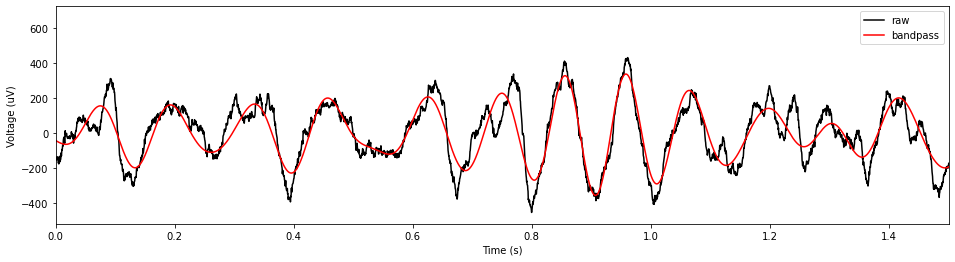

In [4]:
sample = remFolder[3]
lfpREM = sample["data"][0]
metadata = sample["metadata"]

sig = Signal(lfpREM, fs)
sig.filter('bandpass', f_theta, n_seconds_theta)
sig.plot(xlim=(0, 1.5))

In [5]:
metadata

{'RatID': 'Rat4',
 'StudyDay': 'SD9',
 'condition': 'HC',
 'condition_full': 'HomeCage',
 'treatment': 'TreatmentNegative',
 'posstrial_number': 'posttrial3'}

In [14]:
theta = ThetaSignal(lfpREM, fs)
theta.filter('bandpass', f_theta, n_seconds_theta)
theta.segment_cycles()

Phasic periods in the bandpass signal: 47
Periods: 
 [(106769, 108987), (125289, 127831), (171562, 174662), (267133, 272945)]
Tonic periods in the bandpass signal: 865
Periods: 
 [(333, 125289), (127831, 171562), (174662, 267133), (269655, 269888), (272945, 305444)]


In [36]:
sig = ThetaSignal(remFolder[3]["data"][0], 2500)
sig.summary()


Sampling rate: 2500 Hz
Duration: 122.20 seconds
Max value: 665.82 uV
Min value: -461.92 uV
Mean value: -0.00 uV
Standard Deviation: 159.80 uV
Signal Range: 1127.73 uV
Number of Data Points: 305495


In [46]:
sig.filter('bandpass', f_theta, n_seconds_theta)
sig.segment_cycles()

Phasic periods in the bandpass signal: 47
Periods: 
 [(106769, 108987), (125289, 127831), (171562, 174662), (267133, 272945)]
Tonic periods in the bandpass signal: 865
Periods: 
 [(333, 125289), (127831, 171562), (174662, 267133), (269655, 269888), (272945, 305444)]


In [62]:
dfs = []
for tonic in sig.get_tonic():
    df = emd_analysis(tonic, 2500)
    break

Detected cycles before extraction:
<class 'emd.cycles.Cycles'> (380 cycles 1 metrics) 

Finished computing the cycles metrics

Cycles after extraction:
349


In [150]:
bins = np.arange(0.2, 0.8, 0.01)

oc_hist_phasic = [np.zeros(len(bins)-1, dtype=np.int64), np.zeros(len(bins)-1, dtype=np.int64)]
hc_hist_phasic = [np.zeros(len(bins)-1, dtype=np.int64), np.zeros(len(bins)-1, dtype=np.int64)]
oc_hist_tonic = [np.zeros(len(bins)-1, dtype=np.int64), np.zeros(len(bins)-1, dtype=np.int64)]
hc_hist_tonic = [np.zeros(len(bins)-1, dtype=np.int64), np.zeros(len(bins)-1, dtype=np.int64)]

for sample in remFolder:
    lfpREMs = sample["data"]
    metadata = sample["metadata"]
    
    print(metadata)

    condition = metadata["condition"]
    treatment = metadata["treatment"]

    for lfpREM in lfpREMs:
        theta = ThetaSignal(lfpREM, fs)
        theta.filter('lowpass', f_theta, n_seconds_filter)
        theta.segment_cycles()
        
        for tonic in theta.get_tonic():
            df = emd_analysis(tonic, theta.sampling_rate)

            hist_a2d, _ = np.histogram(df["asc2desc"], bins=bins)
            hist_p2t, _ = np.histogram(df["peak2trough"], bins=bins)

            if(condition == 'HC'):
                hc_hist_tonic[0] += hist_a2d
                hc_hist_tonic[1] += hist_p2t
            else:
                oc_hist_tonic[0] += hist_a2d
                oc_hist_tonic[1] += hist_p2t
        
        if(theta.phasic == None):
            break
        
        for phasic in theta.get_phasic():
            df = emd_analysis(phasic, theta.sampling_rate)

            hist_a2d, _ = np.histogram(df["asc2desc"], bins=bins)
            hist_p2t, _ = np.histogram(df["peak2trough"], bins=bins)

            if(condition == 'HC'):
                hc_hist_phasic[0] += hist_a2d
                hc_hist_phasic[1] += hist_p2t
            else:
                oc_hist_phasic[0] += hist_a2d
                oc_hist_phasic[1] += hist_p2t



{'RatID': 'Rat5', 'StudyDay': 'SD5', 'condition': 'OD', 'condition_full': 'ObjectSpace', 'treatment': 'TreatmentPositive', 'posstrial_number': 'posttrial4'}
Phasic periods in the lowpass signal: 0
No phasic periods detected
Tonic periods in the lowpass signal: 663
Periods: 
 [(293, 209426)]
Detected cycles before extraction:
<class 'emd.cycles.Cycles'> (621 cycles 1 metrics) 

Finished computing the cycles metrics

Cycles after extraction:
518
{'RatID': 'Rat3', 'StudyDay': 'SD6', 'condition': 'OD', 'condition_full': 'ObjectSpace', 'treatment': 'TreatmentPositive', 'posstrial_number': 'posttrial5'}
Phasic periods in the lowpass signal: 0
No phasic periods detected
Tonic periods in the lowpass signal: 1144
Periods: 
 [(405, 386983)]
Detected cycles before extraction:
<class 'emd.cycles.Cycles'> (1111 cycles 1 metrics) 

Finished computing the cycles metrics

Cycles after extraction:
950
{'RatID': 'Rat5', 'StudyDay': 'SD6', 'condition': 'HC', 'condition_full': 'HomeCage', 'treatment': 'Tr

ValueError: The designed filter (length: 1875) is longer than the signal (length: 1530). The filter needs to be shortened by decreasing the n_cycles or n_seconds parameter. However, this will decrease the frequency resolution of the filter.

In [ ]:
#{'RatID': 'Rat5', 'StudyDay': 'SD8', 'condition': 'HC', 'condition_full': 'HomeCage', 'treatment': 'TreatmentNegative', 'posstrial_number': 'posttrial3'}


In [ ]:
import matplotlib.pyplot as plt

def plot_bar(feature, bins, ax=None, density=False, **kwargs):

    # Default keyword args
    figsize = kwargs.pop('figsize', (5, 5))
    xlabel = kwargs.pop('xlabel', None)
    xlim = kwargs.pop('xlim', None)
    ylim = kwargs.pop('ylim', None)
    fontsize = kwargs.pop('fontsize', 15)
    alpha = kwargs.pop('alpha', .7)

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Axis style
    ax.set_xlabel(xlabel, size=fontsize)

    if density:
        ax.set_ylabel('Cycles density', size=fontsize)
    else:
        ax.set_ylabel('Number of cycles', size=fontsize)

    if xlim is not None:
        ax.set_xlim(xlim)

    if ylim is not None:
        ax.set_xlim(ylim)
        
    ax.bar(feature, bins=bins, alpha=alpha, density=density, **kwargs)

<BarContainer object of 60 artists>

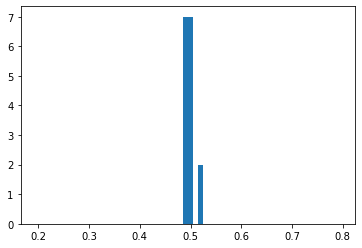

In [144]:
data=oc_hist_phasic[0]
plt.bar(bins[:-1], data, width=0.01)